<font size="+3">Time-series Generative Adversarial Network (TimeGAN)</font>

# Imports & Settings

Adapted from the excellent paper by Jinsung Yoon, Daniel Jarrett, and Mihaela van der Schaar:  
[Time-series Generative Adversarial Networks](https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks),  
Neural Information Processing Systems (NeurIPS), 2019.

- Last updated Date: April 24th 2020
- [Original code](https://bitbucket.org/mvdschaar/mlforhealthlabpub/src/master/alg/timegan/) author: Jinsung Yoon (jsyoon0823@gmail.com)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from pathlib import Path
from tqdm import tqdm

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dense, RNN, GRUCell, Input
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import seaborn as sns

2023-11-30 20:24:53.265781: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-30 20:24:53.289565: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-30 20:24:53.289585: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-30 20:24:53.289597: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-30 20:24:53.293940: I tensorflow/core/platform/cpu_feature_g

In [3]:
tf.config.experimental.list_physical_devices('GPU')
# tf.sysconfig.get_build_info()

2023-11-30 20:24:54.411823: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-30 20:24:54.415042: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-30 20:24:54.415075: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [5]:
sns.set_style('white')

In [6]:
# import h5py

# hpf = h5py.File(hdf_store, "r")
# hpf['quandl'].keys()

# Experiment Path

In [7]:
results_path = Path('time_gan')
if not results_path.exists():
    results_path.mkdir()

In [8]:
experiment = "m4"
dataset = "custom/m4_monthly"

In [9]:
log_dir = results_path / f'experiment_{experiment}'
if not log_dir.exists():
    log_dir.mkdir(parents=True)

In [10]:
hdf_store = 'assets.h5'

# Prepare Data

## Parameters

In [11]:
seq_len = 24
n_seq = 42
batch_size = 128 

In [12]:
tickers = ['BA', 'CAT', 'DIS', 'GE', 'IBM', 'KO']

In [13]:
# def select_data():
#     df = (pd.read_hdf('../data/assets.h5', 'quandl/wiki/prices')
#           .adj_close
#           .unstack('ticker')
#           .loc['2000':, tickers]
#           .dropna())
#     df.to_hdf(hdf_store, 'data/real')

In [14]:
# select_data()

## Plot Series

In [15]:
df = pd.read_hdf(hdf_store, dataset)
df = df.iloc[:len(df)//6]
# axes = df.div(df.iloc[0]).plot(subplots=True,
#                                figsize=(14, 6),
#                                layout=(3, 2),
#                                title=tickers,
#                                legend=False,
#                                rot=0,
#                                lw=1, 
#                                color='k')
# for ax in axes.flatten():
#     ax.set_xlabel('')

# plt.suptitle('Normalized Price Series')
# plt.gcf().tight_layout()
# sns.despine();

In [16]:
df

,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43
0,8000.0,8350.0,8570.0,7700.0,7080.0,6520.0,6070.0,6650.0,6830.0,5710.0,...,5780.0,5700.0,4680.0,4970.0,6850.0,6740.0,7490.0,6250.0,6900.0,5870.0
1,2440.0,2490.0,2710.0,2290.0,1960.0,1990.0,1960.0,2530.0,2640.0,2650.0,...,1770.0,1960.0,1860.0,1340.0,2150.0,2180.0,2030.0,1730.0,1860.0,1880.0
2,2670.0,2590.0,2784.0,2816.0,2888.0,2906.0,2839.0,2860.0,2798.0,2795.0,...,2861.0,2991.0,3063.0,3134.0,3020.0,2947.0,3026.0,3060.0,3008.0,2972.0
3,7264.0,7215.0,7022.0,7040.0,6966.0,6984.0,7025.0,7082.0,6956.0,7014.0,...,6866.0,6814.0,6806.0,6806.0,6855.0,6951.0,6898.0,6898.0,6922.0,6768.0
4,4210.0,4290.0,4250.0,4320.0,4320.0,4330.0,4320.0,4260.0,4220.0,4260.0,...,4470.0,4310.0,4280.0,4220.0,4190.0,4120.0,4150.0,4190.0,4180.0,4320.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,10900.0,9800.0,10200.0,11600.0,11400.0,12600.0,13000.0,12800.0,12300.0,11600.0,...,8000.0,7700.0,7000.0,6100.0,5400.0,6000.0,5300.0,4800.0,5400.0,5400.0
7996,1890.0,2000.0,2350.0,2450.0,2330.0,2270.0,2430.0,2320.0,2560.0,2560.0,...,1460.0,1170.0,1100.0,1120.0,1050.0,990.0,860.0,900.0,850.0,1040.0
7997,2320.0,2320.0,2410.0,2450.0,2900.0,3630.0,3640.0,4130.0,4130.0,3820.0,...,2530.0,2530.0,2360.0,2170.0,1980.0,2060.0,2180.0,2190.0,2180.0,2300.0
7998,2160.0,2180.0,2240.0,2380.0,2400.0,2440.0,2600.0,2750.0,2760.0,2390.0,...,1550.0,1550.0,1600.0,1540.0,1540.0,1430.0,1440.0,1430.0,1390.0,1420.0


## Correlation

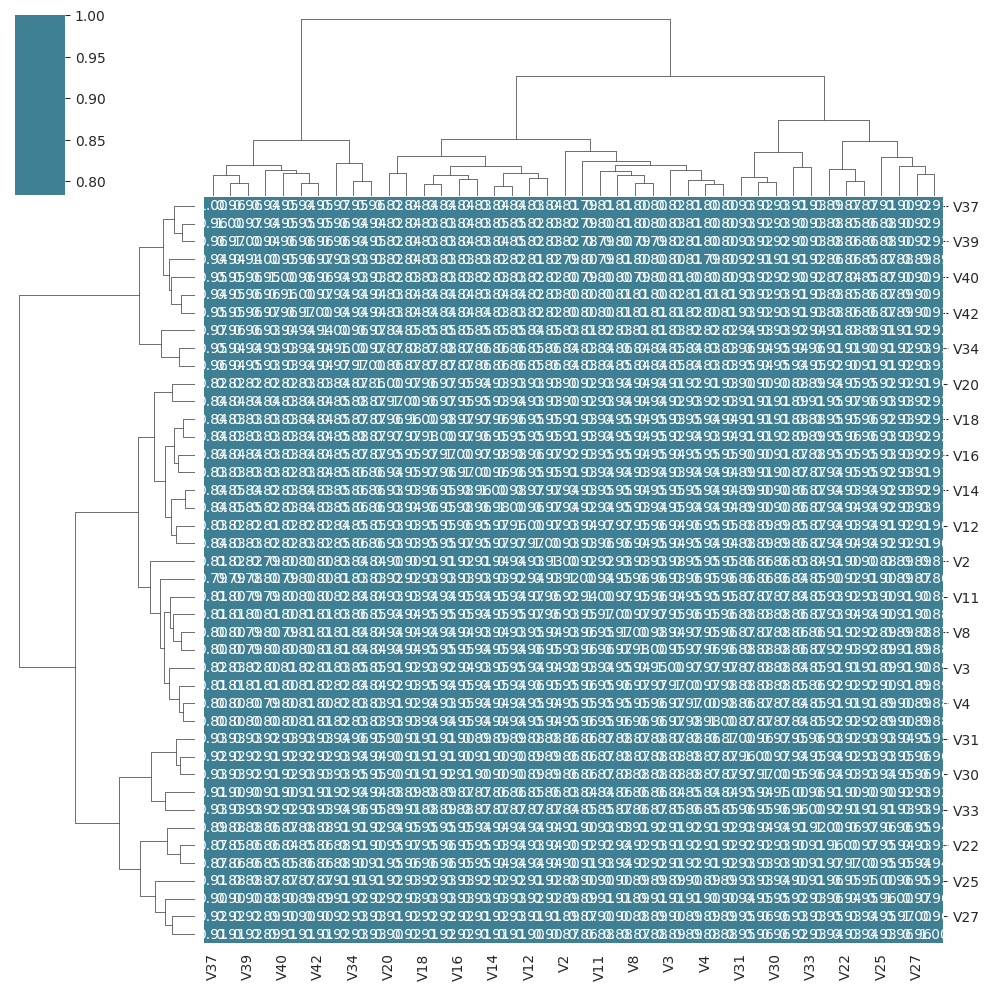

In [17]:
sns.clustermap(df.corr(),
               annot=True,
               fmt='.2f',
               cmap=sns.diverging_palette(h_neg=20,
                                          h_pos=220), center=0);

## Normalize Data

In [18]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df).astype(np.float32)

## Create rolling window sequences

In [19]:
data = []
for i in range(len(df) - seq_len):
    data.append(scaled_data[i:i + seq_len])

n_windows = len(data)

## Create tf.data.Dataset

In [20]:
real_series = (tf.data.Dataset
               .from_tensor_slices(data)
               .shuffle(buffer_size=n_windows)
               .batch(batch_size))
real_series_iter = iter(real_series.repeat())

2023-11-30 20:25:00.280971: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-30 20:25:00.281031: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-30 20:25:00.281049: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-30 20:25:03.416816: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-30 20:25:03.416862: I tensorflow/compile

## Set up random series generator

In [21]:
def make_random_data():
    while True:
        yield np.random.uniform(low=0, high=1, size=(seq_len, n_seq))

We use the Python generator to feed a `tf.data.Dataset` that continues to call the random number generator as long as necessary and produces the desired batch size.

In [22]:
random_series = iter(tf.data.Dataset
                     .from_generator(make_random_data, output_types=tf.float32)
                     .batch(batch_size)
                     .repeat())

# TimeGAN Components

The design of the TimeGAN components follows the author's sample code.

##  Network Parameters

In [23]:
hidden_dim = 24
num_layers = 3

## Set up logger

In [24]:
writer = tf.summary.create_file_writer(log_dir.as_posix())

## Input place holders

In [25]:
X = Input(shape=[seq_len, n_seq], name='RealData')
Z = Input(shape=[seq_len, n_seq], name='RandomData')

## RNN block generator

We keep it very simple and use a very similar architecture for all four components. For a real-world application, they should be tailored to the data.

In [26]:
def make_rnn(n_layers, hidden_units, output_units, name):
    return Sequential([GRU(units=hidden_units,
                           return_sequences=True,
                           name=f'GRU_{i + 1}') for i in range(n_layers)] +
                      [Dense(units=output_units,
                             activation='sigmoid',
                             name='OUT')], name=name)

## Embedder & Recovery

In [27]:
embedder = make_rnn(n_layers=3, 
                    hidden_units=hidden_dim, 
                    output_units=hidden_dim, 
                    name='Embedder')
recovery = make_rnn(n_layers=3, 
                    hidden_units=hidden_dim, 
                    output_units=n_seq, 
                    name='Recovery')

## Generator & Discriminator

In [28]:
generator = make_rnn(n_layers=3, 
                     hidden_units=hidden_dim, 
                     output_units=hidden_dim, 
                     name='Generator')
discriminator = make_rnn(n_layers=3, 
                         hidden_units=hidden_dim, 
                         output_units=1, 
                         name='Discriminator')
supervisor = make_rnn(n_layers=2, 
                      hidden_units=hidden_dim, 
                      output_units=hidden_dim, 
                      name='Supervisor')

# TimeGAN Training

## Settings

In [29]:
train_steps = 10000
gamma = 1

## Generic Loss Functions

In [30]:
mse = MeanSquaredError()
bce = BinaryCrossentropy()

# Phase 1: Autoencoder Training

## Architecture

In [31]:
H = embedder(X)
X_tilde = recovery(H)

autoencoder = Model(inputs=X,
                    outputs=X_tilde,
                    name='Autoencoder')

In [32]:
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(None, 24, 42)]          0         
                                                                 
 Embedder (Sequential)       (None, 24, 24)            12696     
                                                                 
 Recovery (Sequential)       (None, 24, 42)            11850     
                                                                 
Total params: 24546 (95.88 KB)
Trainable params: 24546 (95.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
plot_model(autoencoder,
           to_file=(results_path / 'autoencoder.png').as_posix(),
           show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Autoencoder Optimizer

In [34]:
autoencoder_optimizer = Adam()

## Autoencoder Training Step

In [35]:
@tf.function
def train_autoencoder_init(x):
    with tf.GradientTape() as tape:
        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss_0 = 10 * tf.sqrt(embedding_loss_t0)

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss_0, var_list)
    autoencoder_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

## Autoencoder Training Loop

In [36]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_e_loss_t0 = train_autoencoder_init(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Autoencoder Init', step_e_loss_t0, step=step)

  0%|                                                                                         | 0/10000 [00:00<?, ?it/s]2023-11-30 20:25:19.175694: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-11-30 20:25:20.813278: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f143caeee10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-30 20:25:20.813302: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050, Compute Capability 8.6
2023-11-30 20:25:20.903509: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-30 20:25:21.124351: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████████████████████████████████████████████

## Persist model

In [37]:
# autoencoder.save(log_dir / 'autoencoder')

# Phase 2: Supervised training

## Define Optimizer

In [38]:
supervisor_optimizer = Adam()

## Train Step

In [39]:
@tf.function
def train_supervisor(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        g_loss_s = mse(h[:, 1:, :], h_hat_supervised[:, :-1, :])

    var_list = supervisor.trainable_variables
    gradients = tape.gradient(g_loss_s, var_list)
    supervisor_optimizer.apply_gradients(zip(gradients, var_list))
    return g_loss_s

## Training Loop

In [40]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_g_loss_s = train_supervisor(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Generator Supervised Init', step_g_loss_s, step=step)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:03<00:00, 156.82it/s]


## Persist Model

In [41]:
# supervisor.save(log_dir / 'supervisor')

# Joint Training

## Generator

### Adversarial Architecture - Supervised

In [42]:
E_hat = generator(Z)
H_hat = supervisor(E_hat)
Y_fake = discriminator(H_hat)

adversarial_supervised = Model(inputs=Z,
                               outputs=Y_fake,
                               name='AdversarialNetSupervised')

In [43]:
adversarial_supervised.summary()

Model: "AdversarialNetSupervised"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 24, 42)]          0         
                                                                 
 Generator (Sequential)      (None, 24, 24)            12696     
                                                                 
 Supervisor (Sequential)     (None, 24, 24)            7800      
                                                                 
 Discriminator (Sequential)  (None, 24, 1)             10825     
                                                                 
Total params: 31321 (122.35 KB)
Trainable params: 31321 (122.35 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [44]:
plot_model(adversarial_supervised, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Adversarial Architecture in Latent Space

In [45]:
Y_fake_e = discriminator(E_hat)

adversarial_emb = Model(inputs=Z,
                    outputs=Y_fake_e,
                    name='AdversarialNet')

In [46]:
adversarial_emb.summary()

Model: "AdversarialNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 24, 42)]          0         
                                                                 
 Generator (Sequential)      (None, 24, 24)            12696     
                                                                 
 Discriminator (Sequential)  (None, 24, 1)             10825     
                                                                 
Total params: 23521 (91.88 KB)
Trainable params: 23521 (91.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [47]:
plot_model(adversarial_emb, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Mean & Variance Loss

In [48]:
X_hat = recovery(H_hat)
synthetic_data = Model(inputs=Z,
                       outputs=X_hat,
                       name='SyntheticData')

In [49]:
synthetic_data.summary()

Model: "SyntheticData"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 24, 42)]          0         
                                                                 
 Generator (Sequential)      (None, 24, 24)            12696     
                                                                 
 Supervisor (Sequential)     (None, 24, 24)            7800      
                                                                 
 Recovery (Sequential)       (None, 24, 42)            11850     
                                                                 
Total params: 32346 (126.35 KB)
Trainable params: 32346 (126.35 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [50]:
plot_model(synthetic_data, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [51]:
def get_generator_moment_loss(y_true, y_pred):
    y_true_mean, y_true_var = tf.nn.moments(x=y_true, axes=[0])
    y_pred_mean, y_pred_var = tf.nn.moments(x=y_pred, axes=[0])
    g_loss_mean = tf.reduce_mean(tf.abs(y_true_mean - y_pred_mean))
    g_loss_var = tf.reduce_mean(tf.abs(tf.sqrt(y_true_var + 1e-6) - tf.sqrt(y_pred_var + 1e-6)))
    return g_loss_mean + g_loss_var

## Discriminator

### Architecture: Real Data

In [52]:
Y_real = discriminator(H)
discriminator_model = Model(inputs=X,
                            outputs=Y_real,
                            name='DiscriminatorReal')

In [53]:
discriminator_model.summary()

Model: "DiscriminatorReal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(None, 24, 42)]          0         
                                                                 
 Embedder (Sequential)       (None, 24, 24)            12696     
                                                                 
 Discriminator (Sequential)  (None, 24, 1)             10825     
                                                                 
Total params: 23521 (91.88 KB)
Trainable params: 23521 (91.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [54]:
plot_model(discriminator_model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Optimizers

In [55]:
generator_optimizer = Adam()
discriminator_optimizer = Adam()
embedding_optimizer = Adam()

## Generator Train Step

In [56]:
@tf.function
def train_generator(x, z):
    with tf.GradientTape() as tape:
        y_fake = adversarial_supervised(z)
        generator_loss_unsupervised = bce(y_true=tf.ones_like(y_fake),
                                          y_pred=y_fake)

        y_fake_e = adversarial_emb(z)
        generator_loss_unsupervised_e = bce(y_true=tf.ones_like(y_fake_e),
                                            y_pred=y_fake_e)
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_hat = synthetic_data(z)
        generator_moment_loss = get_generator_moment_loss(x, x_hat)

        generator_loss = (generator_loss_unsupervised +
                          generator_loss_unsupervised_e +
                          100 * tf.sqrt(generator_loss_supervised) +
                          100 * generator_moment_loss)

    var_list = generator.trainable_variables + supervisor.trainable_variables
    gradients = tape.gradient(generator_loss, var_list)
    generator_optimizer.apply_gradients(zip(gradients, var_list))
    return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss

## Embedding Train Step

In [57]:
@tf.function
def train_embedder(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss = 10 * tf.sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss, var_list)
    embedding_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

## Discriminator Train Step

In [58]:
@tf.function
def get_discriminator_loss(x, z):
    y_real = discriminator_model(x)
    discriminator_loss_real = bce(y_true=tf.ones_like(y_real),
                                  y_pred=y_real)

    y_fake = adversarial_supervised(z)
    discriminator_loss_fake = bce(y_true=tf.zeros_like(y_fake),
                                  y_pred=y_fake)

    y_fake_e = adversarial_emb(z)
    discriminator_loss_fake_e = bce(y_true=tf.zeros_like(y_fake_e),
                                    y_pred=y_fake_e)
    return (discriminator_loss_real +
            discriminator_loss_fake +
            gamma * discriminator_loss_fake_e)

In [59]:
@tf.function
def train_discriminator(x, z):
    with tf.GradientTape() as tape:
        discriminator_loss = get_discriminator_loss(x, z)

    var_list = discriminator.trainable_variables
    gradients = tape.gradient(discriminator_loss, var_list)
    discriminator_optimizer.apply_gradients(zip(gradients, var_list))
    return discriminator_loss

## Training Loop

In [60]:
step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = 0
for step in range(train_steps):
    # Train generator (twice as often as discriminator)
    for kk in range(2):
        X_ = next(real_series_iter)
        Z_ = next(random_series)

        # Train generator
        step_g_loss_u, step_g_loss_s, step_g_loss_v = train_generator(X_, Z_)
        # Train embedder
        step_e_loss_t0 = train_embedder(X_)

    X_ = next(real_series_iter)
    Z_ = next(random_series)
    step_d_loss = get_discriminator_loss(X_, Z_)
    if step_d_loss > 0.15:
        step_d_loss = train_discriminator(X_, Z_)

    if step % 1000 == 0:
        print(f'{step:6,.0f} | d_loss: {step_d_loss:6.4f} | g_loss_u: {step_g_loss_u:6.4f} | '
              f'g_loss_s: {step_g_loss_s:6.4f} | g_loss_v: {step_g_loss_v:6.4f} | e_loss_t0: {step_e_loss_t0:6.4f}')

    with writer.as_default():
        tf.summary.scalar('G Loss S', step_g_loss_s, step=step)
        tf.summary.scalar('G Loss U', step_g_loss_u, step=step)
        tf.summary.scalar('G Loss V', step_g_loss_v, step=step)
        tf.summary.scalar('E Loss T0', step_e_loss_t0, step=step)
        tf.summary.scalar('D Loss', step_d_loss, step=step)

     0 | d_loss: 2.1038 | g_loss_u: 0.6685 | g_loss_s: 0.0031 | g_loss_v: 0.1079 | e_loss_t0: 0.0607
 1,000 | d_loss: 1.8548 | g_loss_u: 1.0294 | g_loss_s: 0.0001 | g_loss_v: 0.0200 | e_loss_t0: 0.0224
 2,000 | d_loss: 1.8866 | g_loss_u: 1.0675 | g_loss_s: 0.0000 | g_loss_v: 0.0169 | e_loss_t0: 0.0223
 3,000 | d_loss: 1.8360 | g_loss_u: 1.0782 | g_loss_s: 0.0000 | g_loss_v: 0.0174 | e_loss_t0: 0.0214
 4,000 | d_loss: 1.8175 | g_loss_u: 1.1403 | g_loss_s: 0.0000 | g_loss_v: 0.0155 | e_loss_t0: 0.0205
 5,000 | d_loss: 1.8868 | g_loss_u: 1.0835 | g_loss_s: 0.0000 | g_loss_v: 0.0159 | e_loss_t0: 0.0227
 6,000 | d_loss: 1.7944 | g_loss_u: 1.1378 | g_loss_s: 0.0000 | g_loss_v: 0.0179 | e_loss_t0: 0.0221
 7,000 | d_loss: 1.7976 | g_loss_u: 1.2032 | g_loss_s: 0.0000 | g_loss_v: 0.0254 | e_loss_t0: 0.0194
 8,000 | d_loss: 1.8927 | g_loss_u: 1.0998 | g_loss_s: 0.0000 | g_loss_v: 0.0206 | e_loss_t0: 0.0199
 9,000 | d_loss: 1.8158 | g_loss_u: 1.3814 | g_loss_s: 0.0001 | g_loss_v: 0.0166 | e_loss_t

## Persist Synthetic Data Generator

In [61]:
synthetic_data.save(log_dir / 'synthetic_data.keras')

# Generate Synthetic Data

In [62]:
generated_data = []
for i in range(int(n_windows / batch_size)):
    Z_ = next(random_series)
    d = synthetic_data(Z_)
    generated_data.append(d)

In [63]:
len(generated_data)

62

In [64]:
generated_data = np.array(np.vstack(generated_data))
generated_data.shape

(7936, 24, 42)

In [65]:
np.save(log_dir / 'generated_data.npy', generated_data)

## Rescale

In [66]:
generated_data = (scaler.inverse_transform(generated_data
                                           .reshape(-1, n_seq))
                  .reshape(-1, seq_len, n_seq))
generated_data.shape

(7936, 24, 42)

## Persist Data

In [67]:
with pd.HDFStore(hdf_store) as store:
    store.put(f'data/synthetic/{experiment}', pd.DataFrame(generated_data.reshape(-1, n_seq)))

## Plot sample Series

In [68]:
synthetic_data = np.load(f'time_gan/experiment_{experiment}/generated_data.npy')
synthetic_data.shape

(7936, 24, 42)

In [69]:
def get_real_data():
    df = pd.read_hdf(hdf_store, dataset)
    df = df.iloc[:len(df)//6]

    # Preprocess the dataset:
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)

    data = []
    for i in range(len(df) - seq_len):
        data.append(scaled_data[i:i + seq_len])
    return data

real_data = get_real_data()

In [70]:
n = len(real_data)

In [71]:
np.asarray(real_data).shape

(7976, 24, 42)

In [72]:
real_data = real_data[:synthetic_data.shape[0]]

In [73]:
sample_size = 250
idx = np.random.permutation(len(real_data))[:sample_size]

# Data preprocessing
real_sample = np.asarray(real_data)[idx]
synthetic_sample = np.asarray(synthetic_data)[idx]

In [74]:
real_sample_2d = real_sample.reshape(-1, seq_len)
synthetic_sample_2d = synthetic_sample.reshape(-1, seq_len)

real_sample_2d.shape, synthetic_sample_2d.shape

((10500, 24), (10500, 24))

In [75]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [76]:
pca = PCA(n_components=2)
pca.fit(real_sample_2d)
pca_real = (pd.DataFrame(pca.transform(real_sample_2d)).assign(Data='Real'))
pca_synthetic = (pd.DataFrame(pca.transform(synthetic_sample_2d)).assign(Data='Synthetic'))
pca_result = pd.concat([pca_real, pca_synthetic]).rename(columns={0: '1st Component', 1: '2nd Component'})

In [77]:
tsne_data = np.concatenate((real_sample_2d,
                            synthetic_sample_2d), axis=0)
tsne = TSNE(n_components=2,
            verbose=1,
            perplexity=40)
tsne_result = tsne.fit_transform(tsne_data)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 21000 samples in 0.000s...
[t-SNE] Computed neighbors for 21000 samples in 1.000s...
[t-SNE] Computed conditional probabilities for sample 1000 / 21000
[t-SNE] Computed conditional probabilities for sample 2000 / 21000
[t-SNE] Computed conditional probabilities for sample 3000 / 21000
[t-SNE] Computed conditional probabilities for sample 4000 / 21000
[t-SNE] Computed conditional probabilities for sample 5000 / 21000
[t-SNE] Computed conditional probabilities for sample 6000 / 21000
[t-SNE] Computed conditional probabilities for sample 7000 / 21000
[t-SNE] Computed conditional probabilities for sample 8000 / 21000
[t-SNE] Computed conditional probabilities for sample 9000 / 21000
[t-SNE] Computed conditional probabilities for sample 10000 / 21000
[t-SNE] Computed conditional probabilities for sample 11000 / 21000
[t-SNE] Computed conditional probabilities for sample 12000 / 21000
[t-SNE] Computed conditional probabilities for sa

In [78]:
tsne_result = pd.DataFrame(tsne_result, columns=['X', 'Y']).assign(Data='Real')
tsne_result.loc[sample_size*6:, 'Data'] = 'Synthetic'

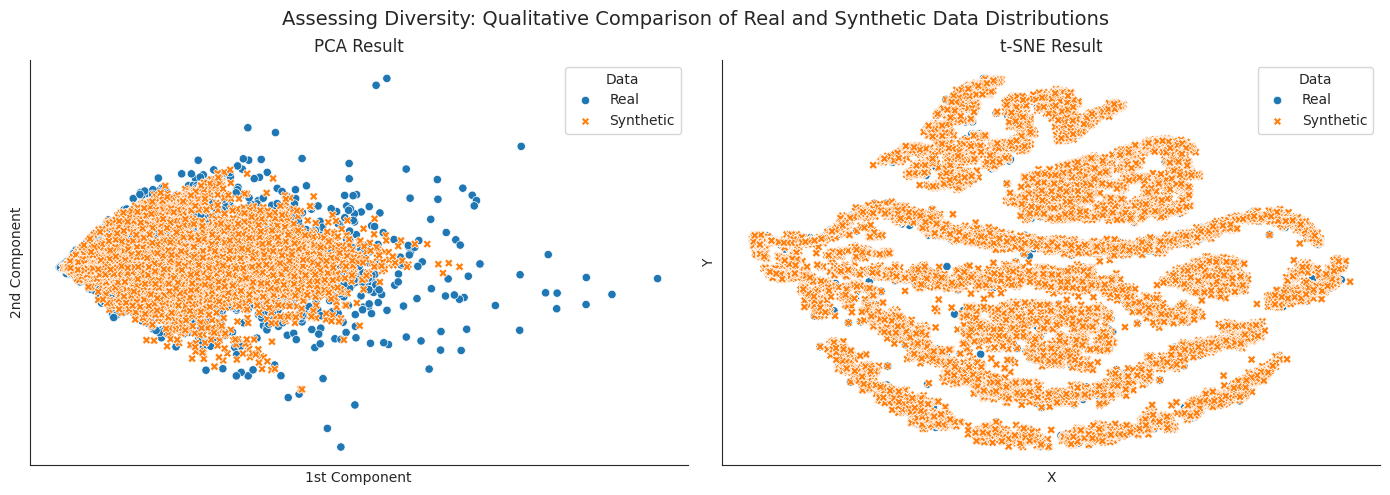

In [95]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

sns.scatterplot(x='1st Component', y='2nd Component', data=pca_result,
                hue='Data', style='Data', ax=axes[0])
sns.despine()
axes[0].set_title('PCA Result')


sns.scatterplot(x='X', y='Y',
                data=tsne_result,
                hue='Data', 
                style='Data', 
                ax=axes[1])
sns.despine()
for i in [0, 1]:
    axes[i].set_xticks([])
    axes[i].set_yticks([])

axes[1].set_title('t-SNE Result')
fig.suptitle('Assessing Diversity: Qualitative Comparison of Real and Synthetic Data Distributions', 
             fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.88);
plt.savefig(log_dir / "plot.png")

In [90]:
pca_result[pca_result["Data"] == "Real"]

,1st Component,2nd Component,Data
0,-0.011386,-0.027436,Real
1,0.071128,0.166162,Real
2,-0.383050,-0.016438,Real
3,-0.290385,-0.050488,Real
4,-0.214779,-0.022219,Real
...,...,...,...
10495,0.985350,-0.117655,Real
10496,0.998650,0.300146,Real
10497,0.824899,-0.110415,Real
10498,0.674212,0.224160,Real
